<a href="https://colab.research.google.com/github/Mshuning/DNSC6290/blob/main/Assignment%205/assignment_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## License 

Copyright 2021 Patrick Hall (jphall@gwu.edu), Shuning Ma (shuningma@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

# Assignment 5

#### Imports and inits

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import itertools                                              # for cartesian product of parameters
import xgboost as xgb                                         # base xgboost package for python
from interpret.glassbox import ExplainableBoostingClassifier      # interpret ebm class
from interpret.perf import ROC                                    # ROC measure for ebm
import numpy as np                                                # for basic array manipulation                            
import pandas as pd                                               # for dataframe manipulation
import time                                                       # for timers

# plotting functionality
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # necessary for custom legends

# display plots in notebook
%matplotlib inline

# set numpy random seed for better reproducibility
SEED = 12345 
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

#### Start global timer

In [ ]:
tic = time.time()

#### Import data

In [ ]:
data = pd.read_csv('../data/hmda_train_preprocessed.csv')
test = pd.read_csv('../data/hmda_test_preprocessed.csv')

#### Assign basic modeling roles

In [ ]:
y_name = 'high_priced'

## Fit interpretable model

#### Split data into train and validation partitions 

In [ ]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### XGBoost Machine

#### Retrain most accurate model above 0.8 AIR to debug

In [ ]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """
    
    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate

In [ ]:
# params dict for remediated models
rem_gs_params = {'colsample_bytree': [0.3],
             'colsample_bylevel': [0.3],
             'eta': [0.05],
             'max_depth': [3],
             'reg_alpha': [0.0005],
             'reg_lambda': [0.0005],
             'subsample': [0.3],
             'min_child_weight': [10], 
             'gamma': [0.2]}

mono_constraints = (1, 1, 1, -1, 0, -1, 0, 1, 0, 1)

rem_x_names = ['debt_to_income_ratio_std',
          'income_std',
          'term_360',
          'property_value_std',
          'intro_rate_period_std',
          'loan_to_value_ratio_std',
          'loan_amount_std',
          'debt_to_income_ratio_missing',
          'conforming',
          'no_intro_rate_period_std']

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[rem_x_names], train[y_name])
dvalid = xgb.DMatrix(valid[rem_x_names], valid[y_name])

# retrain
rem_mxgb = xgb_grid(dtrain, dvalid, gs_params=rem_gs_params, n_models=1, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

Grid search run 1/1:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.2}
Grid search new best score discovered at iteration 1/1: 0.7907.
---------- ----------


In [ ]:
# Get training AUC
xgb_grid(dtrain, dtrain, gs_params=rem_gs_params, n_models=1, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

Grid search run 1/1:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.2}
Grid search new best score discovered at iteration 1/1: 0.7894.
---------- ----------


## Sensitivity Analysis: Stress Testing

#### Simulate recession conditions in validation data

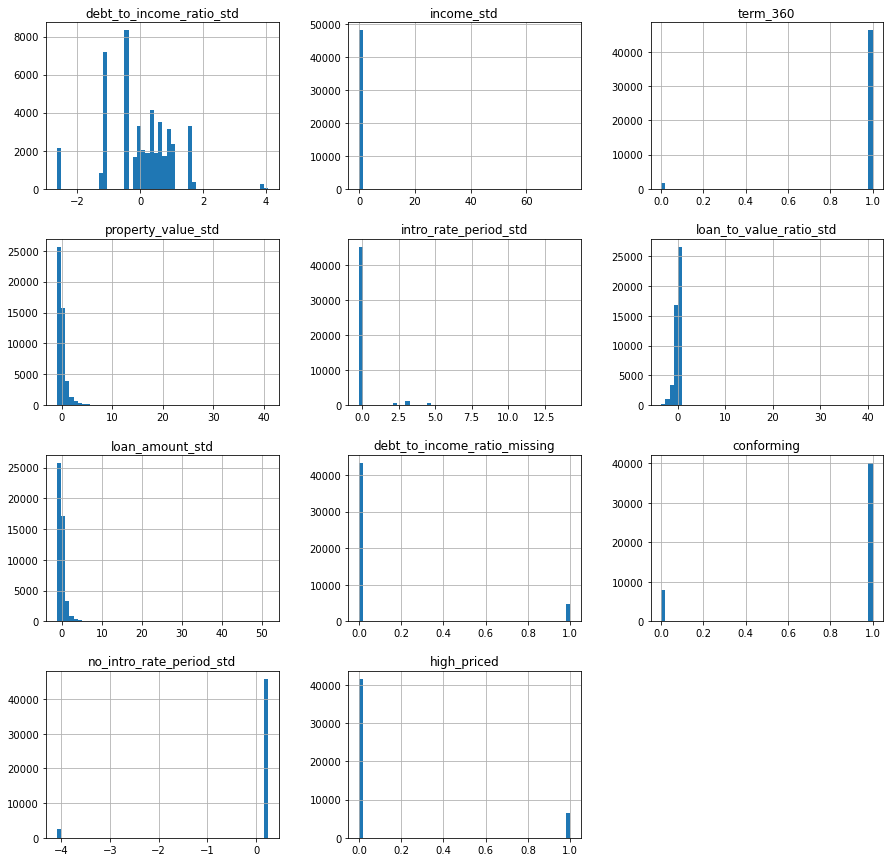

In [ ]:
np.random.seed(SEED) # set seed for this cell

rec_valid = valid.copy(deep=True) # deep copy of validation data

# use severity variable to control how many customers are affected
severity = 0.1
affected = np.random.rand(len(rec_valid)) < severity

# decrease property values by 5%
rec_valid.loc[affected, 'property_value_std'] = rec_valid.loc[affected, 'property_value_std'] * 0.95

# less intro rates
rec_valid.loc[affected, 'no_intro_rate_period_std'] = 0.2443944

# more missing debt-to-income ratios 
rec_valid.loc[affected, 'debt_to_income_ratio_missing'] = 1

# lower income by 5%
rec_valid.loc[affected, 'income_std'] = rec_valid.loc[affected, 'income_std'] * 0.95

# less conforming loans
rec_valid.loc[affected, 'conforming'] = 0

# shorter intro rate periods
rec_valid.loc[affected, 'intro_rate_period_std'] = rec_valid.loc[affected, 'intro_rate_period_std'] * 0.95

# 5% higher debt-to-income ratios 
rec_valid.loc[affected, 'debt_to_income_ratio_std'] = rec_valid.loc[affected, 'debt_to_income_ratio_std'] * 1.05

# more long loans
rec_valid.loc[affected, 'term_360'] = 1

# update target
rec_valid.loc[affected, y_name] = np.random.choice(2, len(rec_valid.loc[affected, y_name]))

# visualize results
_ = rec_valid[rem_x_names + [y_name]].hist(bins=50, figsize=(15, 15))

#### Find AUC for best model in simulated recession conditions

In [ ]:
rec_dvalid = xgb.DMatrix(rec_valid[rem_x_names], rec_valid[y_name])
rec_rem_mxgb = xgb_grid(dtrain, rec_dvalid, gs_params=rem_gs_params, n_models=1, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

Grid search run 1/1:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.2}
Grid search new best score discovered at iteration 1/1: 0.6215.
---------- ----------


Note the major drop in performance for recession conditions, which is normal for all models and usually worse for complex ML models. It's not unlikely that the more constrained monotonic GBM or penalized GLM could perform better in these conditions. 

Also, this tells us we need to monitor this model carefully, because when recession conditions begin, this model will fail quickly.

## Residual Analysis

#### Calculate predictions and logloss residuals for all data 

In [ ]:
# shortcut names
yhat_name = 'phat'
r_name = 'r' 

ddata = xgb.DMatrix(data[rem_x_names], data[y_name])
# calculate predictions
rem_mxgb_phat = pd.DataFrame(rem_mxgb.predict(ddata, iteration_range=(0, rem_mxgb.best_ntree_limit)), columns=['phat']) 
rem_mxgb_phat = pd.concat([data.reset_index(drop=True), rem_mxgb_phat], axis=1)

# calculate logloss residuals
rem_mxgb_phat[r_name] = -rem_mxgb_phat[y_name]*np.log(rem_mxgb_phat[yhat_name]) -\
                       (1 - rem_mxgb_phat[y_name])*np.log(1 - rem_mxgb_phat[yhat_name])   

#### Plot residuals

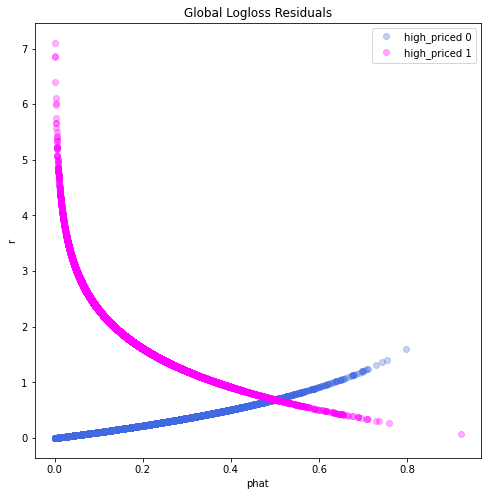

In [ ]:
# initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))         

# plot groups with appropriate color
color_list = ['royalblue', 'magenta'] 
c_idx = 0
groups = rem_mxgb_phat.groupby(y_name) # define groups for levels of PAY_0
for name, group in groups:
    ax_.plot(group.phat, group.r, 
             label=' '.join([y_name, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1
    
# annotate plot
_ = plt.xlabel(yhat_name)
_ = plt.ylabel(r_name)
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')

Residuals are very unbalanced. This model struggles to predict when customers will recieve a high-priced loan correctly. It does much better when predicting customers will NOT receive a high-priced loan. There are also some very noticable outliers.

## Remediation: Remove Outliers

#### Find outliers

In [ ]:
rem_mxgb_phat.sort_values(by='r', ascending=False).head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat,r
2650,2650,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.948060,-0.442940,0.244394,-0.215304,1.900015,-0.052781,-2.527547,1,0.000821,7.105468
82041,82041,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,-0.954117,-2.973067,0.244394,-0.215304,0.697459,-0.052781,-0.425131,1,0.001047,6.861403
100712,100712,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,2.036004,-0.483396,0.244394,-0.215304,2.023354,-0.052781,-1.156406,1,0.001069,6.841026
110822,110822,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.892723,-0.874794,0.244394,-0.215304,1.252485,-0.007738,-1.156406,1,0.001650,6.406950
83113,83113,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.760806,-0.277030,0.244394,-0.215304,0.697459,0.017208,-0.059493,1,0.002213,6.113442


#### Remove worst outliers

In [ ]:
n_remove = 10
rem_data = data.copy(deep=True)
rem_data.drop(list(rem_mxgb_phat.sort_values(by='r', ascending=False).head(n=n_remove).index), axis=0, inplace=True)

## Remediation: Down-sample to Increase Signal from High-priced Loans

In [ ]:
inverse_proportion_remove = 2 # corresponds to keeping 1 - (1/inverse_proportion_remove) rows
rem_data.drop(list(rem_data[rem_data[y_name] == 0].index)[::inverse_proportion_remove], axis=0, inplace=True)

#### Retrain remediated XGBoost

In [ ]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

# execute split
split = np.random.rand(len(rem_data)) < split_ratio
rem_train = rem_data[split]
rem_valid = rem_data[~split]

# summarize split
print('Remediated train data rows = %d, columns = %d' % (rem_train.shape[0], rem_train.shape[1]))
print('Remediated validation data rows = %d, columns = %d' % (rem_valid.shape[0], rem_valid.shape[1]))

# retrain
rem_dtrain = xgb.DMatrix(rem_train[rem_x_names], rem_train[y_name])
rem_dvalid = xgb.DMatrix(rem_valid[rem_x_names], rem_valid[y_name])
rem_mxgb2 = xgb_grid(rem_dtrain, rem_dvalid, gs_params=rem_gs_params, n_models=1, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

Remediated train data rows = 61518, columns = 23
Remediated validation data rows = 26393, columns = 23
Grid search run 1/1:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.2}
Grid search new best score discovered at iteration 1/1: 0.7847.
---------- ----------


#### Test remediated XGBoost on true validation data

In [ ]:
# calculate predictions
rem_mxgb2 = xgb_grid(rem_dtrain, dvalid, gs_params=rem_gs_params, n_models=1, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

Grid search run 1/1:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.2}
Grid search new best score discovered at iteration 1/1: 0.7920.
---------- ----------


Dropping outliers and under-sampling increases true AUC!

#### End global timer

In [ ]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 61.24 s.
